In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -uq '/content/gdrive/My Drive/chexpertdataset.zip'

In [0]:
import cv2
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

In [0]:
df = pd.read_csv('CheXpert-v1.0-small/train.csv') # Earlier, df_train
df_val = pd.read_csv('CheXpert-v1.0-small/valid.csv')
# We shall make the train_test split later using ImageDataGenerator's parameter
# df = pd.concat([df_train, df_val])
# df = df.reset_index(drop=True)

In [0]:
def clean_df(df):
  # Focusing only on 5 classes:
  df = df[[
    'Path', 
    'Atelectasis',
    'Cardiomegaly',
    'Consolidation',
    'Edema',
    'Pleural Effusion'
  ]]

  # Handling the NaN values
  df = df.fillna(0)

  # Handling the uncertain values
  ## Different policy for each feature:
  u_ones = ['Atelectasis', 'Edema']
  u_zeros = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']
  df[u_ones]  = df[u_ones].replace(-1, 1)
  df[u_zeros] = df[u_zeros].replace(-1, 0)

  return df

In [0]:
df = clean_df(df)
df_val = clean_df(df_val)

In [0]:
#df = df.sample(frac=1)[:10000]

# The Data Generators

In [0]:
# Defining constants:
BATCH_SIZE = 32
IMAGE_SIZE = 224 # Apparently, due to a bug in Keras, NASNetLarge only accepts 331 as image size
CLASSES = [ 
  'Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Pleural Effusion'
]

Generating a sample for datagen fitting for featurewise normalization and featurewise centering.

In [0]:
# Constants
FRAC = 0.003 # Fraction of total data to be taken as sample
SHAPE = (320, 390, 3) # Common shape for featurewise centering & normalization

sample_paths = df['Path'].sample(frac=FRAC).to_numpy()
X_temp = np.array([np.array(cv2.imread(path, 1), dtype=float) for path in sample_paths])
X_sample = np.array([x for x in X_temp if x.shape == SHAPE])

In [0]:
from keras.preprocessing.image import ImageDataGenerator as IDG

datagen = IDG(
    rescale=1./255, 
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0.1,
    zoom_range = 0.1,
    shear_range = 0.01,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip = False,
    validation_split = 0.1,
    fill_mode = 'nearest'
)

datagen.fit(X_sample)

test_datagen = IDG(
    rescale=1./255,
    featurewise_center=True, 
    featurewise_std_normalization=True
)

test_datagen.fit(X_sample)

del(X_sample)

In [0]:
def get_gen():
  train_gen = datagen.flow_from_dataframe(
      dataframe = df,
      x_col = 'Path',
      y_col = CLASSES,
      class_mode='raw',
      seed=42,
      shuffle=True,
      target_size=(IMAGE_SIZE, IMAGE_SIZE), 
      batch_size=32, 
      subset = 'training'
  )

  val_gen = datagen.flow_from_dataframe(
      dataframe = df,
      x_col = 'Path',
      y_col = CLASSES,
      class_mode='raw',
      seed=42,
      shuffle=True,
      target_size=(IMAGE_SIZE, IMAGE_SIZE), 
      batch_size=32, # We can use much larger batches for evaluation, but RAM crashes :/
      subset = 'validation'
  )

  return train_gen, val_gen

# Cyclic LR

It seems that our code gets stuck on a loss plateau. Let's try to implement the cyclic LR callback. 

The below callback implements a cyclical learning rate policy (CLR).
The method cycles the learning rate between two boundaries with
some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
The amplitude of the cycle can be scaled on a per-iteration or per-cycle basis.This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ``` 
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.

In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    
    def __init__(self, base_lr=0.001, max_lr=0.01, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

# The Model

In [0]:
# Building on top of the base:
from keras.applications import NASNetMobile as NNL
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, GlobalAveragePooling2D
from keras.layers.core import Flatten, Dense, Dropout

def build_model():
  # The convolutional base:
  model_base = NNL(
       include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet'
      )
  
  #model_base.trainable = False
  # Unfreezing last N layers:
  for layer in model_base.layers:
      layer.trainable = True

  model = Sequential()
  model.add(model_base) # Adding the base as a layer
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(5, activation='sigmoid'))
  
  return model

# Training and Validating

In [0]:
from keras.metrics import categorical_accuracy as catacc
from keras.metrics import AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

auc = AUC(name='auc')

adam = Adam(learning_rate=0.00005) # 0.05 of default

es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=3)
mc = ModelCheckpoint(
    filepath='nnl-1.h5', verbose=1 #, save_best_only=True
)
clr = CyclicLR(base_lr=0.00005, max_lr=0.0001)
rlrp = ReduceLROnPlateau(monitor='auc', factor=0.5, min_lr=0.000001)

cb_list = [es, mc] # Will add clr later, as we'll have to tune it's hyperparameters

model = build_model()
model.compile(
    loss='binary_crossentropy',
    optimizer= adam,
    metrics=[auc, catacc] # Earlier, 'acc' 
)

In [44]:
train_gen, val_gen = get_gen()

Found 201073 validated image filenames.
Found 22341 validated image filenames.


In [0]:
# Training constants:
TRAIN_STEPS = train_gen.n//BATCH_SIZE
VAL_STEPS   = val_gen.n//BATCH_SIZE
N_EPOCHS = 1

In [46]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=TRAIN_STEPS,
    epochs=N_EPOCHS,
    validation_data=val_gen,
    validation_steps=VAL_STEPS,
    callbacks = cb_list,
)

Epoch 1/1
6283/6283 [==============================] - 7468s 1s/step - loss: 0.4714 - auc: 0.7722 - categorical_accuracy: 0.3438 - val_loss: 0.4114 - val_auc: 0.8255 - val_categorical_accuracy: 0.3630

Epoch 00001: saving model to nnl-1.h5


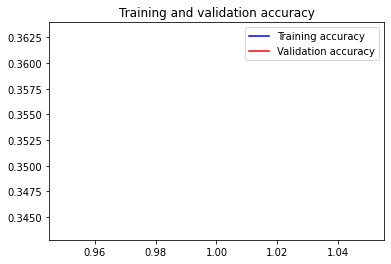

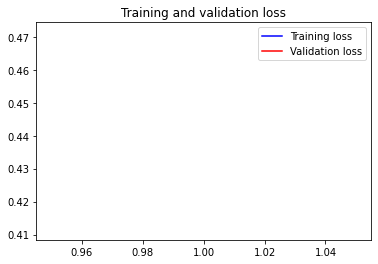

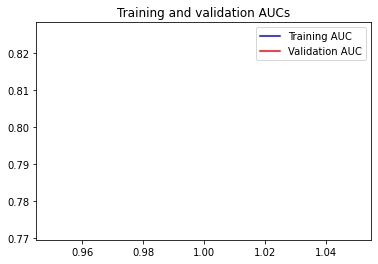

In [47]:
cat_acc = history.history['categorical_accuracy']
val_cat_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
auc     = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(cat_acc) + 1)

plt.plot(epochs, cat_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_cat_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Training and validation AUCs')
plt.legend()
plt.show()

## Test Generator

In [48]:
test_gen = test_datagen.flow_from_dataframe(
    dataframe = df_val,
    #directory = '/content/CheXpert-v1.0-small/valid',
    x_col = 'Path',
    y_col = CLASSES, #'classes',
    class_mode='raw',
    #validate_filenames = False,
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=1, 
    shuffle = False,
    #classes = columns,
)  

Found 234 validated image filenames.


# ROC-AUC Curves

In [0]:
y_labels = df_val[CLASSES].to_numpy()
y_pred = model.predict_generator(test_gen, steps=test_gen.n) 

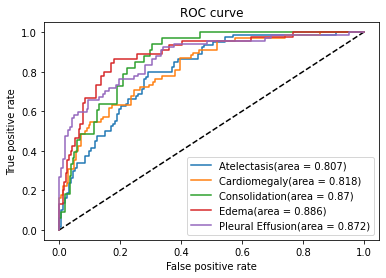

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

for i in range(len(CLASSES)):
   fpr, tpr, thresholds = roc_curve(y_labels[:, i], y_pred[:, i])
   individual_auc = auc(fpr, tpr)
   plt.plot(fpr, tpr, label= (CLASSES[i] + '(area = {0:.3g})'.format(individual_auc)))

    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
results = model.evaluate_generator(test_gen)

In [52]:
results

[0.3070610463619232, 0.7797778844833374, 0.39743590354919434]